### Introduction to Machine Learning in Finance and Insurance (Spring 2024)
# Project 2: Insurance Claim Prediction

### Team members: LastName1 FirstName1, LastName2 FirstName2, LastName3 FirstName3

In [1]:
### Import all the Python libraries you are going to use
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
### Fix random seed for reproducibility
np.random.seed(4)

# Exercise 1. Poisson GLM.

Exposure needs fixing because it was read as a string with commas instead of a float. Thus, decimal=","

In [3]:
url = "https://raw.githubusercontent.com/yannickhaenggi/CAS-ETH-ML-Project-2/38eff2e1defee11becdb249fdf86b39713345137/data/freMTPL2freq.csv"
df = pd.read_csv(url, sep=';', decimal=",")  # Specify the delimiter
df.head()

,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Exposure,ClaimNb
0,4,9,23,100,B6,Regular,7887,R31,0.76,0
1,4,6,26,100,B6,Regular,2308,R31,0.74,0
2,4,6,26,100,B6,Regular,2308,R31,0.11,0
3,7,4,44,50,B6,Regular,37,R94,0.83,0
4,5,2,29,90,B6,Regular,335,R91,0.69,0


In [4]:
# 2. Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
Exposure      0
ClaimNb       0
dtype: int64


No-Null Count = Number of entries

In [5]:
# Show basic info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   VehPower    678007 non-null  int64  
 1   VehAge      678007 non-null  int64  
 2   DrivAge     678007 non-null  int64  
 3   BonusMalus  678007 non-null  int64  
 4   VehBrand    678007 non-null  object 
 5   VehGas      678007 non-null  object 
 6   Density     678007 non-null  int64  
 7   Region      678007 non-null  object 
 8   Exposure    678007 non-null  float64
 9   ClaimNb     678007 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 51.7+ MB
None


In [6]:
# Show summary statistics
print(df.describe(include='all'))

             VehPower         VehAge        DrivAge     BonusMalus VehBrand  \
count   678007.000000  678007.000000  678007.000000  678007.000000   678007   
unique            NaN            NaN            NaN            NaN       11   
top               NaN            NaN            NaN            NaN      B12   
freq              NaN            NaN            NaN            NaN   166024   
mean         6.454653       7.044218      45.499061      59.761588      NaN   
std          2.050902       5.666235      14.137492      15.636700      NaN   
min          4.000000       0.000000      18.000000      50.000000      NaN   
25%          5.000000       2.000000      34.000000      50.000000      NaN   
50%          6.000000       6.000000      44.000000      50.000000      NaN   
75%          7.000000      11.000000      55.000000      64.000000      NaN   
max         15.000000     100.000000     100.000000     230.000000      NaN   

         VehGas        Density  Region       Exposu

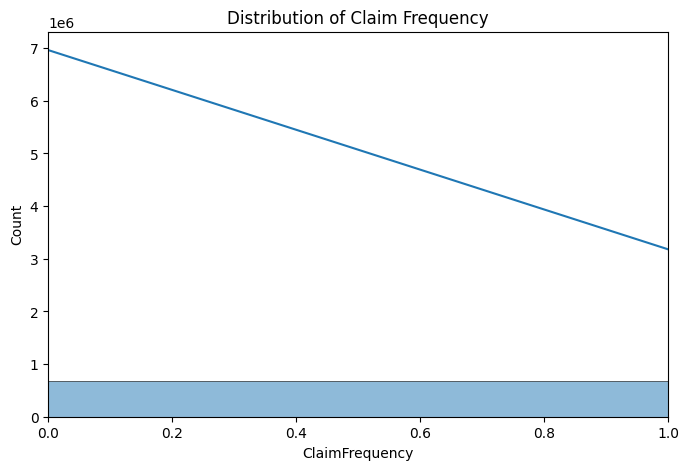

In [7]:
# Distribution of Claim Frequency

df['ClaimFrequency'] = df['ClaimNb'] / df['Exposure']

plt.figure(figsize=(8, 5))
sns.histplot(df['ClaimFrequency'], bins=100, kde=True)
plt.title('Distribution of Claim Frequency')
plt.xlim(0, 1)
plt.show()

The distribution of the target variable ClaimFrequency is highly right-skewed, with the vast majority of observations concentrated near zero. This reflects the real-world nature of motor insurance, where most policyholders do not file any claims during the exposure period. The long tail indicates a small number of policyholders with higher claim frequencies, which will be critical to capture for accurate modeling.

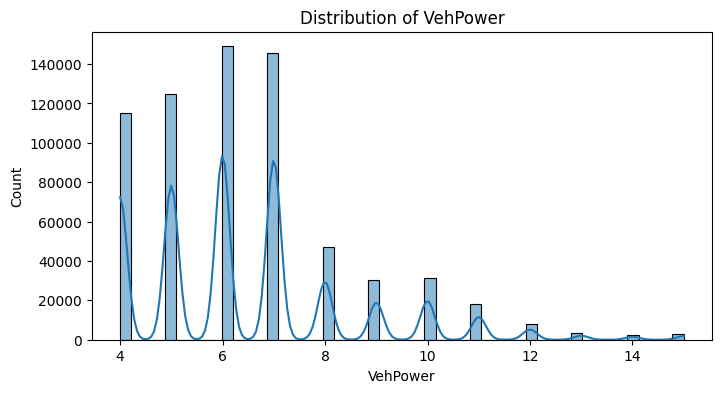

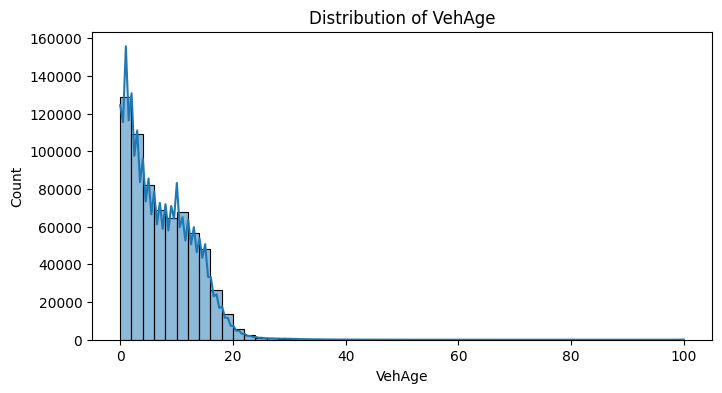

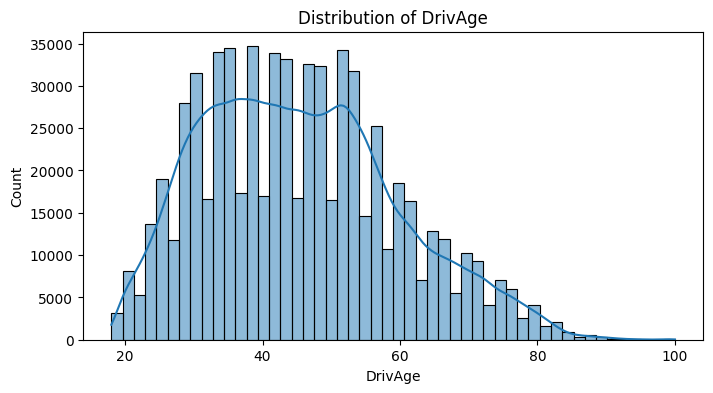

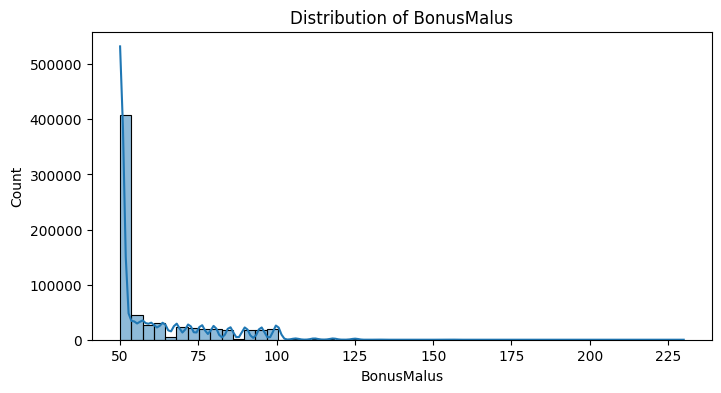

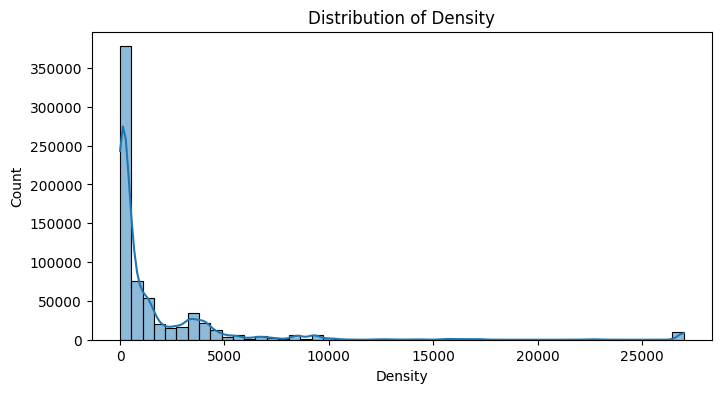

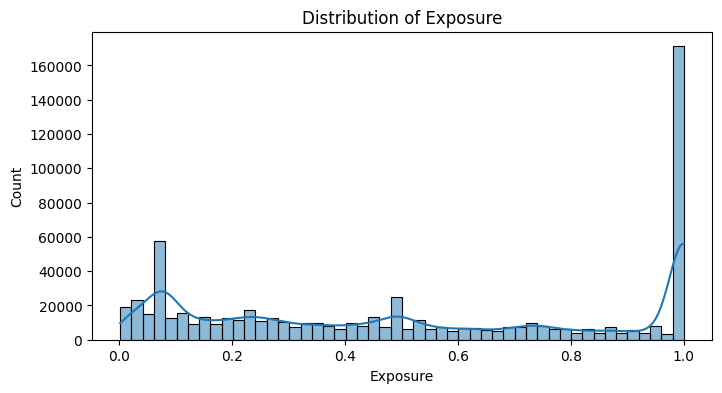

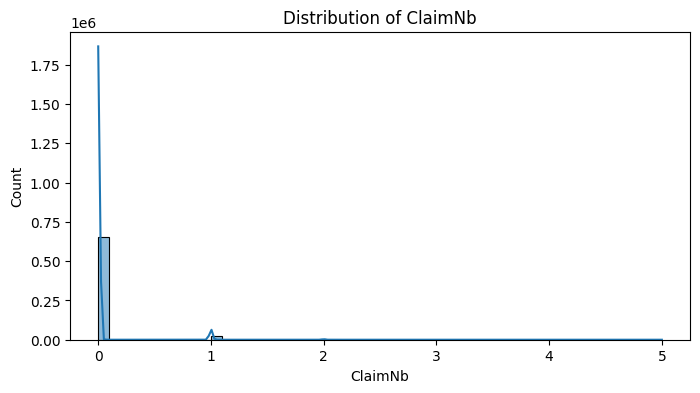

In [8]:
# Numerical features distribution
numeric_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'Exposure', 'ClaimNb']

for col in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

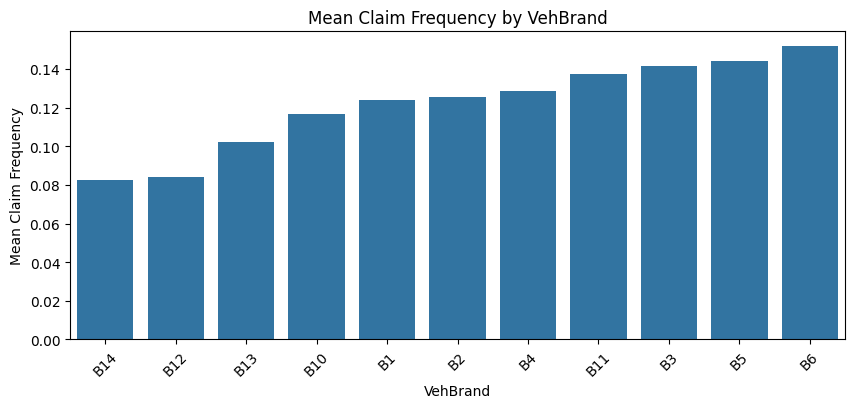

In [9]:
vehbrand_means = df.groupby('VehBrand')['ClaimFrequency'].mean().sort_values()

plt.figure(figsize=(10, 4))
sns.barplot(x=vehbrand_means.index, y=vehbrand_means.values)
plt.title('Mean Claim Frequency by VehBrand')
plt.ylabel('Mean Claim Frequency')
plt.xticks(rotation=45)
plt.show()

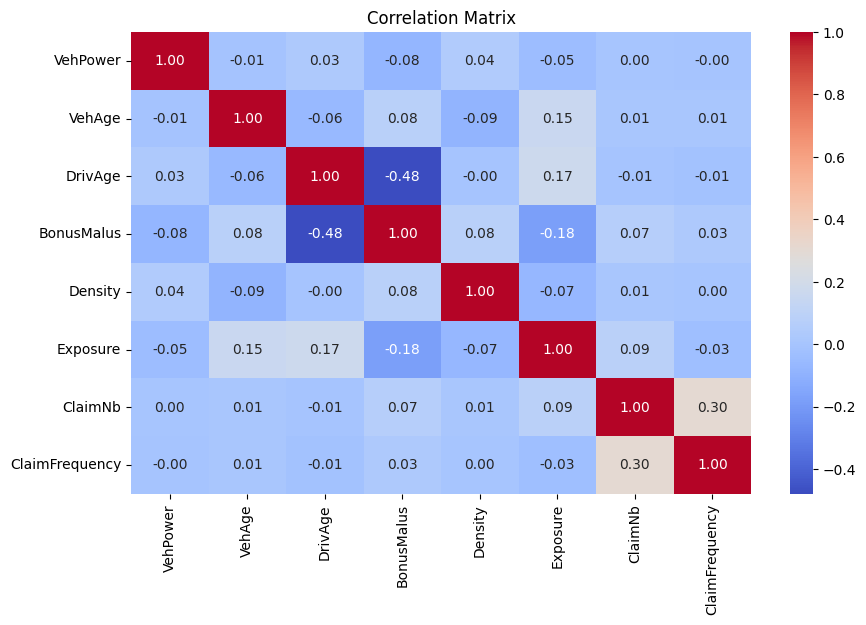

In [10]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
corr = df[numeric_features + ['ClaimFrequency']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

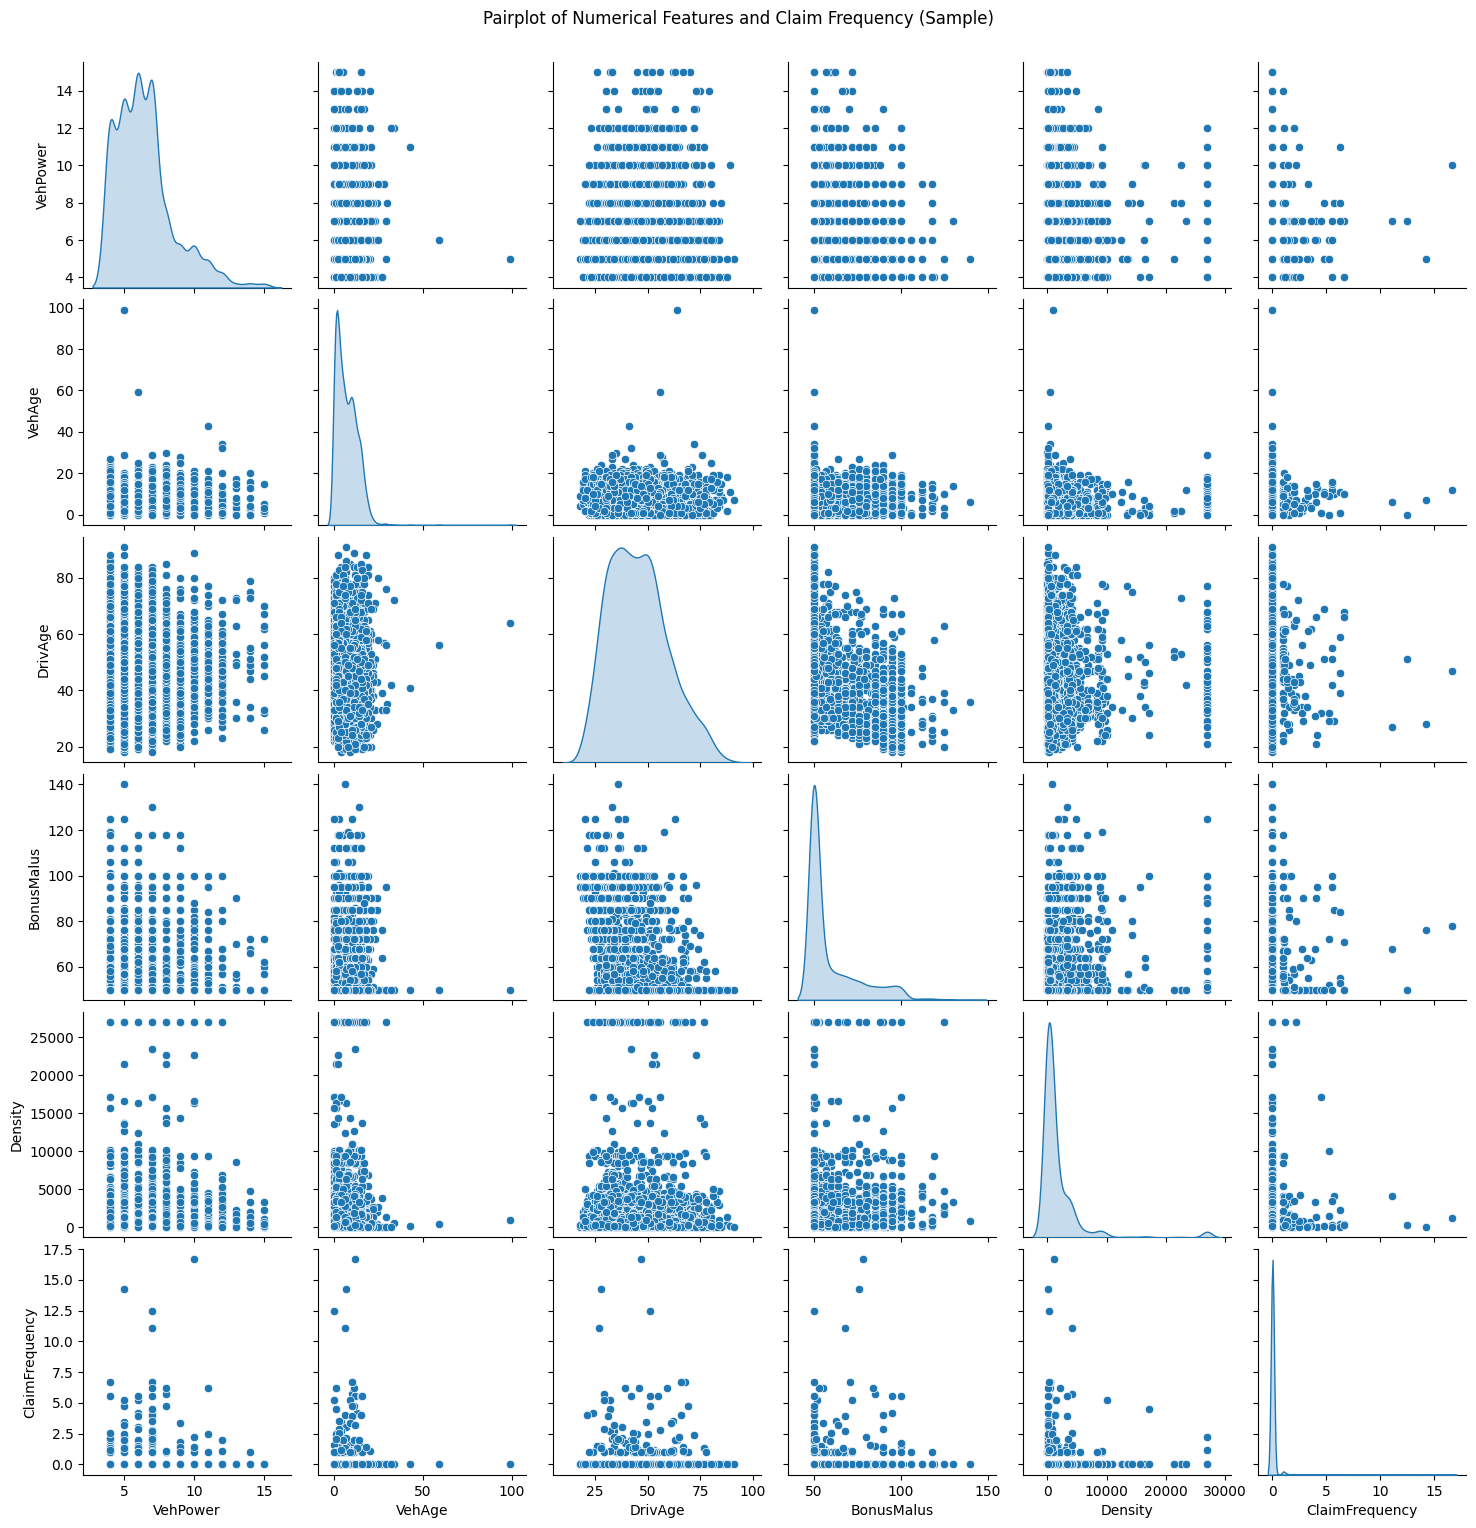

In [11]:
# Select a small sample for better readability and speed
df_sample = df[['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'ClaimFrequency']].sample(3000, random_state=23)

# Create the pairplot
sns.pairplot(df_sample, diag_kind='kde')
plt.suptitle("Pairplot of Numerical Features and Claim Frequency (Sample)", y=1.02)
plt.show()

### Preprocessing Checklist Step	Feature(s)	Action
1. Remove zero-exposure rows	Exposure	These don’t contribute useful info and will cause division issues
2. Drop or cap outliers	ClaimFrequency, optionally Density, BonusMalus	Limit claim frequency (e.g. < 0.3) for robust training
3. One-Hot Encoding	VehBrand, VehGas, Region	Required for ML models like GLM or NN
4. Scaling	VehPower, VehAge, DrivAge, Density, BonusMalus	Especially for neural networks; optional for GLM
5. Optional binning	DrivAge, VehAge	Can help GLM if done wisely
6. Type Checks	All columns	Ensure numeric features are really numeric, categorical are strings
7. Target prep	ClaimFrequency	Decide whether to model as continuous or Poisson count model with ClaimNb as target

In [12]:
# 1. Drop zero-exposure rows
df = df[df['Exposure'] > 0]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678007 entries, 0 to 678006
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   VehPower        678007 non-null  int64  
 1   VehAge          678007 non-null  int64  
 2   DrivAge         678007 non-null  int64  
 3   BonusMalus      678007 non-null  int64  
 4   VehBrand        678007 non-null  object 
 5   VehGas          678007 non-null  object 
 6   Density         678007 non-null  int64  
 7   Region          678007 non-null  object 
 8   Exposure        678007 non-null  float64
 9   ClaimNb         678007 non-null  int64  
 10  ClaimFrequency  678007 non-null  float64
dtypes: float64(2), int64(6), object(3)
memory usage: 56.9+ MB


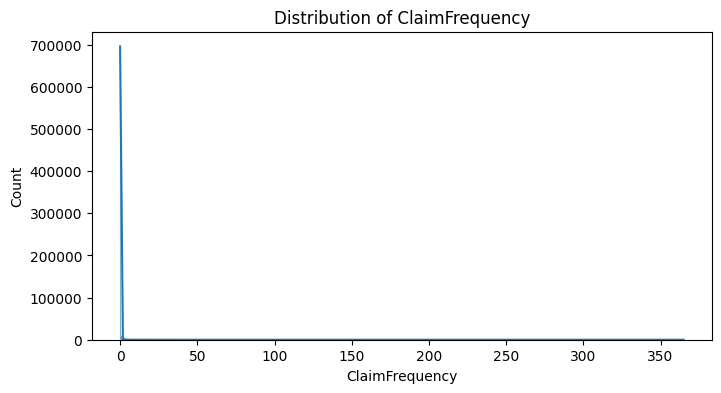

In [14]:
# Claim Frequency feature distribution
claim_freq = ['ClaimFrequency']

for col in claim_freq:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=1000, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [15]:
# What are the max values?
print("Max Claim Frequency:", df['ClaimFrequency'].max())

# How many rows are affected by the filter?
print("Rows before filter:", len(df))
print("Rows above 0.3:", (df['ClaimFrequency'] >= 0.3).sum())
print("Rows after filter:", (df['ClaimFrequency'] < 0.3).sum())

Max Claim Frequency: 365.000000000008
Rows before filter: 678007
Rows above 0.3: 24938
Rows after filter: 653069


In [16]:
# Show quantiles
df['ClaimNb'].quantile([0.995, 0.996, 0.997, 0.998, 0.999999])
df['ClaimNb'].unique()


array([0, 1, 2, 3, 4, 5])

In [17]:
# Count how many entries have ClaimNb > 5
print("Number of rows with ClaimNb > 5:", (df['ClaimNb'] > 5).sum())

Number of rows with ClaimNb > 5: 0


In [18]:
# Count how many entries have VehAge > 50
print("Number of rows with VehAge > 50:", (df['VehAge'] > 50).sum())

# Optionally, show those rows (if any)
df[df['VehAge'] > 50]

Number of rows with VehAge > 50: 97


,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Exposure,ClaimNb,ClaimFrequency
2180,9,99,19,100,B6,Regular,874,R31,0.13,0,0.0
2181,9,99,19,100,B6,Regular,874,R31,0.27,0,0.0
3228,6,99,37,50,B6,Diesel,295,R52,0.08,0,0.0
6413,9,100,20,100,B6,Regular,874,R31,0.21,0,0.0
6414,9,100,20,90,B6,Regular,874,R31,0.78,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
661306,7,66,66,72,B1,Regular,78,R72,0.66,0,0.0
663316,4,53,68,50,B1,Regular,741,R24,0.62,0,0.0
663857,6,54,54,63,B1,Regular,27000,R11,0.38,0,0.0
666045,6,60,51,50,B1,Diesel,1974,R54,0.10,0,0.0


 Optional modeling decision:

    In practice, Poisson models can be sensitive to extreme targets.

    That's why clipping is commonly done in industry, but it's not required by the assignment.

In [19]:
# 2. Clip ClaimFrequency to remove extreme outliers
#clip_threshold = df['ClaimFrequency'].quantile(0.995)
#df = df[df['ClaimFrequency'] < clip_threshold]

In [20]:
# 2. Clip ClaimFrequency to remove extreme outliers
#df = df[df['ClaimFrequency'] < 0.3]

In [21]:
# Amount of outliers removed from the dataset

# 678007 - len(df)

Pre-process the following dataset features as indicated in (2a):

    VehPower: transform to log(VehPower)

    VehAge: convert to categorical with levels [0,6), [6,13), [13,∞)

    DrivAge: transform to log(DrivAge)

    BonusMalus: transform to log(BonusMalus)

    Density: transform to log(Density)

Feature	Transformation
VehPower --> log(): Reduces skew, models diminishing marginal impact of power

VehAge --> Binned categorical:	Captures nonlinear effects (e.g. aging effects change over time)

DrivAge -->	log():	Makes age effects smoother and more interpretable

BonusMalus --> log():	Often very skewed, log helps normalize and stabilize impact

Density	--> log():	Extreme variation in population density — log compresses scale

In [22]:
# Log transforms
df['VehPower_log'] = np.log(df['VehPower'])
df['DrivAge_log'] = np.log(df['DrivAge'])
df['BonusMalus_log'] = np.log(df['BonusMalus'])
df['Density_log'] = np.log(df['Density'])

# VehAge binning
df['VehAge_binned'] = pd.cut(df['VehAge'], bins=[-1, 6, 13, np.inf], labels=['[0,6)', '[6,13)', '[13,∞)'])

In [23]:
df.head()

,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,Exposure,ClaimNb,ClaimFrequency,VehPower_log,DrivAge_log,BonusMalus_log,Density_log,VehAge_binned
0,4,9,23,100,B6,Regular,7887,R31,0.76,0,0.0,1.386294,3.135494,4.605170,8.972971,"[6,13)"
1,4,6,26,100,B6,Regular,2308,R31,0.74,0,0.0,1.386294,3.258097,4.605170,7.744137,"[0,6)"
2,4,6,26,100,B6,Regular,2308,R31,0.11,0,0.0,1.386294,3.258097,4.605170,7.744137,"[0,6)"
3,7,4,44,50,B6,Regular,37,R94,0.83,0,0.0,1.945910,3.784190,3.912023,3.610918,"[0,6)"
4,5,2,29,90,B6,Regular,335,R91,0.69,0,0.0,1.609438,3.367296,4.499810,5.814131,"[0,6)"


In [24]:
from sklearn.preprocessing import StandardScaler

# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=['VehBrand', 'VehGas', 'Region', 'VehAge_binned'], drop_first=False)

# 4. Define input features, target, and sample weights

# Drop unneeded columns and raw versions of log-transformed features
drop_cols = ['VehPower', 'DrivAge', 'BonusMalus', 'Density', 'VehAge', 'ClaimFrequency', 'ClaimNb', 'Exposure']
X = df_encoded.drop(columns=drop_cols)

# Target and sample weights
y = df_encoded['ClaimNb'] # Target variable not input future
weights = df_encoded['Exposure'] # Used as sample weight in Poisson GLM loss not an input future
# ClaimFrequency is a derived variable for analysis and visualization and not used in modeling

In [25]:
df_encoded.head()

,VehPower,VehAge,DrivAge,BonusMalus,Density,Exposure,ClaimNb,ClaimFrequency,VehPower_log,DrivAge_log,...,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94,"VehAge_binned_[0,6)","VehAge_binned_[6,13)","VehAge_binned_[13,∞)"
0,4,9,23,100,7887,0.76,0,0.0,1.386294,3.135494,...,False,False,False,False,False,False,False,False,True,False
1,4,6,26,100,2308,0.74,0,0.0,1.386294,3.258097,...,False,False,False,False,False,False,False,True,False,False
2,4,6,26,100,2308,0.11,0,0.0,1.386294,3.258097,...,False,False,False,False,False,False,False,True,False,False
3,7,4,44,50,37,0.83,0,0.0,1.945910,3.784190,...,False,False,False,False,False,False,True,True,False,False
4,5,2,29,90,335,0.69,0,0.0,1.609438,3.367296,...,False,False,False,False,True,False,False,True,False,False


In [26]:
# 5. Train-Val-Test split
from sklearn.model_selection import train_test_split

# 90/10 sample test set
X_temp, X_test, y_temp, y_test, w_temp, w_test = train_test_split(X, y, weights, test_size=0.1, random_state=4)

# Split remaining into train and val (20% for validation)
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_temp, y_temp, w_temp, test_size=0.2, random_state=4)

# Step 6: Scale numeric features (only!)
features_to_scale = ['VehPower_log', 'DrivAge_log', 'BonusMalus_log', 'Density_log']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
X_val_scaled[features_to_scale] = scaler.transform(X_val[features_to_scale])
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

Use the trained Poisson GLM to predict the expected number of claims per policy (i.e. λ^iλ^i​) for the train, validation, and test sets.

In [27]:
# Train Poisson GLM using sklearn.linear_model.Poisson_Regressor
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fit the Poisson GLM
poisson_glm = PoissonRegressor(alpha=0, max_iter=1000)
poisson_glm.fit(X_train_scaled, y_train, sample_weight=w_train)

# Predict mean claim frequency (λ̂_i) for each set
lambda_train = poisson_glm.predict(X_train_scaled)
lambda_val = poisson_glm.predict(X_val_scaled)
lambda_test = poisson_glm.predict(X_test_scaled)

Implement the Poisson deviance loss to measure how well the predicted claim counts match the actual counts, scaled by each policy’s Exposure.

* Ensures small Exposure values don’t dominate the loss
* Uses numerical tricks (np.maximum(..., 1e-10)) to avoid log(0)

In [28]:
# Define weighted loss function (Poisson deviance)
def weighted_poisson_deviance(y_true, y_pred, exposure):
    term1 = y_pred
    term2 = y_true * np.log(np.maximum(y_pred, 1e-10))  # avoid log(0)
    term3 = y_true * np.log(np.maximum(y_true, 1e-10))  # 0 log 0 = 0
    return 2 * np.sum(exposure * (term1 - term2 + term3 - y_true)) / np.sum(exposure)

Compute the Mean Absolute Error (MAE) and Mean Squared Error (MSE) but weight each sample by its Exposure to take into consideration that short-exposure policies should contribute less to the overall error than long-exposure ones.

In [29]:
# Compute Weighted Metrics
def weighted_mae(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

def weighted_mse(y_true, y_pred, weights):
    return np.sum(weights * (y_true - y_pred)**2) / np.sum(weights)

In [30]:
# Print MAE, MSE and loss on train and test data sets

for name, y_true, y_pred, w in [
    ('Train', y_train, lambda_train, w_train),
    ('Validation', y_val, lambda_val, w_val),
    ('Test', y_test, lambda_test, w_test),
]:
    print(f"\n{name} Set Metrics:")
    print("Weighted MAE:", weighted_mae(y_true, y_pred, w))
    print("Weighted MSE:", weighted_mse(y_true, y_pred, w))
    print("Poisson Deviance Loss:", weighted_poisson_deviance(y_true, y_pred, w))


Train Set Metrics:
Weighted MAE: 0.0953892206121464
Weighted MSE: 0.053367032969958046
Poisson Deviance Loss: 0.2981911493280457

Validation Set Metrics:
Weighted MAE: 0.09519086542447892
Weighted MSE: 0.053395925826244646
Poisson Deviance Loss: 0.29723298510682467

Test Set Metrics:
Weighted MAE: 0.09577840340832496
Weighted MSE: 0.05363977637526321
Poisson Deviance Loss: 0.300805857497954


Proceeding with Task 2(c) focused on adding interaction and polynomial terms to enhance model performance. These engineered features are:

* DrivAge (log already used, so we'll reuse the log version)
* DrivAge²
* BonusMalus * DrivAge
* BonusMalus * DrivAge²

In [31]:
# Add engineered features: Polynomial and interaction terms (based on raw values)
df_encoded['DrivAge_squared'] = df['DrivAge'] ** 2
df_encoded['Interaction_BM_DA'] = df['BonusMalus'] * df['DrivAge']
df_encoded['Interaction_BM_DA2'] = df['BonusMalus'] * (df['DrivAge'] ** 2)

In [32]:
# Redefine X2 with new engineered features included
X2 = df_encoded.drop(columns=['VehPower', 'DrivAge', 'BonusMalus', 'Density', 'VehAge',
                              'ClaimFrequency', 'ClaimNb', 'Exposure'])

y2 = df_encoded['ClaimNb']
w2 = df_encoded['Exposure']

# Redo the same train/val/test split as before (same random seed)
X2_temp, X2_test, y2_temp, y2_test, w2_temp, w2_test = train_test_split(X2, y2, w2, test_size=10000, random_state=4)
X2_train, X2_val, y2_train, y2_val, w2_train, w2_val = train_test_split(X2_temp, y2_temp, w2_temp, test_size=0.2, random_state=4)

In [33]:
# Scale the original log features and new polynomial/interaction features
features_to_scale_2 = ['VehPower_log', 'DrivAge_log', 'BonusMalus_log', 'Density_log',
                       'DrivAge_squared', 'Interaction_BM_DA', 'Interaction_BM_DA2']

scaler2 = StandardScaler()
X2_train_scaled = X2_train.copy()
X2_val_scaled = X2_val.copy()
X2_test_scaled = X2_test.copy()

X2_train_scaled[features_to_scale_2] = scaler2.fit_transform(X2_train[features_to_scale_2])
X2_val_scaled[features_to_scale_2] = scaler2.transform(X2_val[features_to_scale_2])
X2_test_scaled[features_to_scale_2] = scaler2.transform(X2_test[features_to_scale_2])

In [34]:
from sklearn.linear_model import PoissonRegressor

poisson_glm2 = PoissonRegressor(alpha=0, max_iter=1000)
poisson_glm2.fit(X2_train_scaled, y2_train, sample_weight=w2_train)

# Predict
lambda2_train = poisson_glm2.predict(X2_train_scaled)
lambda2_test = poisson_glm2.predict(X2_test_scaled)

In [35]:
# Print MAE, MSE and Poisson loss for the engineered feature model (Model 2)

for name, y_true, y_pred, w in [
    ('Train', y2_train, lambda2_train, w2_train),
    ('Validation', y2_val, poisson_glm2.predict(X2_val_scaled), w2_val),
    ('Test', y2_test, lambda2_test, w2_test),
]:
    print(f"\n{name} Set Metrics (Model 2 – with engineered features):")
    print("Weighted MAE:", weighted_mae(y_true, y_pred, w))
    print("Weighted MSE:", weighted_mse(y_true, y_pred, w))
    print("Poisson Deviance Loss:", weighted_poisson_deviance(y_true, y_pred, w))



Train Set Metrics (Model 2 – with engineered features):
Weighted MAE: 0.09519295193647796
Weighted MSE: 0.05336679845676385
Poisson Deviance Loss: 0.2973476349357306

Validation Set Metrics (Model 2 – with engineered features):
Weighted MAE: 0.09576222691256207
Weighted MSE: 0.05360275163463569
Poisson Deviance Loss: 0.30013881653774727

Test Set Metrics (Model 2 – with engineered features):
Weighted MAE: 0.09575129333026779
Weighted MSE: 0.0528889976245725
Poisson Deviance Loss: 0.2974240559866317


In [36]:
# Compute test set losses
loss_model1 = weighted_poisson_deviance(y_test, lambda_test, w_test)
loss_model2 = weighted_poisson_deviance(y2_test, lambda2_test, w2_test)

# Compute relative improvement
improvement_pct = 100 * (loss_model1 - loss_model2) / loss_model1

# Print comparison
print("\nPoisson Deviance Comparison on Test Set:")
print(f"Model 1 (original features):   {loss_model1:.4f}")
print(f"Model 2 (with engineered features): {loss_model2:.4f}")
print(f"Relative Improvement: {improvement_pct:.2f}%")

# Auto conclusion
if loss_model2 < loss_model1:
    print("\nConclusion: Adding engineered interaction and polynomial features improved the model's performance, reducing the test set Poisson deviance by {:.2f}%.".format(improvement_pct))
else:
    print("\nConclusion: The engineered features did not improve performance; the original model had lower Poisson deviance on the test set.")



Poisson Deviance Comparison on Test Set:
Model 1 (original features):   0.3008
Model 2 (with engineered features): 0.2974
Relative Improvement: 1.12%

Conclusion: Adding engineered interaction and polynomial features improved the model's performance, reducing the test set Poisson deviance by 1.12%.


# Exercise 2. Poisson feedforward neural network.

In [37]:
# Implement and train a neural network model
# You can use Keras (see the notebook "Project 2 - Insurance Claim Prediction - Sandbox")


In [38]:
# Print MAE, MSE and loss on train and test data sets


In [39]:
import tensorflow as tf
import random

np.random.seed(4)
random.seed(4)
tf.random.set_seed(4)
